In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [0]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [0]:
env = gym.make("Pong-v0")

In [0]:
learning_rate = 0.01
state_size = 6400
n_actions = env.action_space.n # number of available actions

learning_rate = 0.01
episodes = 10
epochs = 1000
baseline = True # constant baseline or not

In [0]:
def preprocess(image):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 2D float array """
    image = image[35:195] # crop
    image = image[::2,::2,0] # downsample by factor of 2
    image[image == 144] = 0 # erase background (background type 1)
    image[image == 109] = 0 # erase background (background type 2)
    image[image != 0] = 1 # everything else (paddles, ball) just set to 1
    return np.reshape(image.astype(np.float).ravel(), [80,80])

In [0]:
def discount_reward(r, gamma=0.99, normalization=False):
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, len(r))):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    
    if normalization:
        mean = np.mean(discounted_r)
        std = np.std(discounted_r)
        discounted_r = (discounted_r - mean) / std
        
    return list(discounted_r)

In [0]:
class PolicyGradient():
    def __init__(self, learning_rate=0.01, state_size=state_size, action_size=n_actions, name="PolicyGradient"):

        with tf.name_scope("inputs"):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name="inputs")
            self.actions_ = tf.placeholder(tf.int32, [None, action_size], name="actions")
            self.discounted_episodes_rewards_ = tf.placeholder(tf.float32, [None,], name="discounted_episodes_rewards_")
        
        with tf.name_scope("layers"):
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, num_outputs=256, weights_initializer=tf.contrib.layers.xavier_initializer())
          #  self.fc2 = tf.contrib.layers.fully_connected(self.inputs_, num_outputs=128, weights_initializer=tf.contrib.layers.xavier_initializer())

        with tf.name_scope("flatten"):
            self.flatten = tf.contrib.layers.flatten(self.fc1)
            self.logits = tf.layers.dense(inputs = self.flatten, units = action_size, activation = tf.nn.relu, 
                                     kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())

        with tf.name_scope("softmax"):
            self.action_distribution = tf.nn.softmax(self.logits)

        with tf.name_scope("loss"):
            self.neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits = self.logits, labels = self.actions_)
            self.loss = tf.reduce_mean(self.neg_log_prob * self.discounted_episodes_rewards_)
            self.learn = tf.train.RMSPropOptimizer(learning_rate).minimize(self.loss)


In [9]:
tf.reset_default_graph()
Pong = PolicyGradient(name='Pong', learning_rate=learning_rate, state_size=state_size, action_size=n_actions)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
# Initialize the simulation
env.reset()
all_rewards = []

with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    
    # Each epoch
    for epoch in range(epochs):
        
        # Store action, state and reward
        all_states, all_actions, all_discount_rewards = [], [], []
        running_rewards = []
        
        for episode in range(episodes):
            
            state = env.reset()
            episode_rewards = []
            
            while True:            
                # Select action and play that action
                action_probability_distribution = sess.run(Pong.action_distribution, feed_dict={Pong.inputs_: preprocess(state).reshape(1, state_size)})
                action = np.random.choice(range(action_probability_distribution.shape[1]), p=action_probability_distribution.ravel())
                new_state, reward, done, _ = env.step(action)
                
                # Record action, state and reward
                all_states.append(preprocess(state).reshape(1, state_size))
                episode_rewards.append(reward)

                selected_action = np.zeros(action_probability_distribution.shape[1])
                selected_action[action] = 1
                all_actions.append(selected_action)
                
                # Set current state to new state
                state = new_state
                
                if done:
                    # Discounted reward per episode
                    dis_rewards = discount_reward(episode_rewards)
                    all_discount_rewards += dis_rewards
                    
                    # Total reward per episode
                    running_rewards.append(sum(episode_rewards))
                    break
        
        # Baseline 
        if baseline: 
            all_discount_rewards -= np.mean(all_discount_rewards)
            all_discount_rewards /= np.std(all_discount_rewards)
         
        # Update policy gradient
        _, _= sess.run([Pong.loss, Pong.learn], 
                                     feed_dict={Pong.inputs_: np.vstack(all_states),
                                     Pong.actions_: np.vstack(all_actions),
                                     Pong.discounted_episodes_rewards_: all_discount_rewards })           
        
        # Average reward per episodes in epoch
        epoch_reward = np.mean(running_rewards)
        all_rewards.append(epoch_reward)
#         print('-----------------------------')
#         print('epoch ' + str(epoch) + ' finished') 
#         print('average reward per episode in epoch:',epoch_reward)

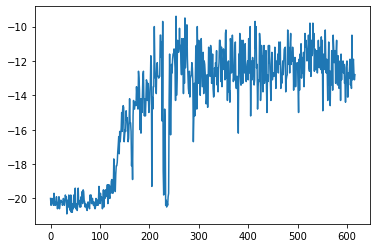

In [13]:
plt.plot(all_rewards)
plt.show()